## 1. Environment Setup

In [29]:
import sys
import warnings
import os

# Fix for potential OpenMP runtime conflicts
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from pathlib import Path
from IPython.display import display, Markdown

from factor_analyzer import FactorAnalyzer, calculate_kmo, calculate_bartlett_sphericity
from factor_analyzer.factor_analyzer import calculate_kmo

warnings.filterwarnings('ignore')

# Ensure output directories exist
Path('plots').mkdir(exist_ok=True)
Path('tables').mkdir(exist_ok=True)

# Plot settings
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

RANDOM_SEED = 67
np.random.seed(RANDOM_SEED)

POPULATION = 'professional'

print("✓ Libraries loaded")
print(f"✓ Random seed: {RANDOM_SEED}")
print(f"✓ Population: {POPULATION.upper()}")

✓ Libraries loaded
✓ Random seed: 67
✓ Population: PROFESSIONAL


## 2. Load Data and Metadata

In [30]:
# Load development sample for EFA
df_dev = pd.read_csv('data/AIRS_dev.csv')

# Load item metadata from Phase 0
with open('../data/airs_28item_complete.json', 'r', encoding='utf-8') as f:
    item_metadata = json.load(f)

# Extract structure
predictor_items = item_metadata['predictor_items']  # 24 items for EFA
outcome_items = item_metadata['outcome_items']  # 4 BI items (not in EFA)
constructs = item_metadata['constructs']
metadata = item_metadata['metadata']
positive_items = item_metadata['positive_items']
negative_items = item_metadata['negative_items']

print(f"Development sample: N = {len(df_dev)}")
print(f"Predictor items for EFA: {len(predictor_items)}")
print(f"Outcome items (BI): {len(outcome_items)}")
print(f"\nConstructs: {list(constructs.keys())}")

# Sample size considerations
n_dev = len(df_dev)
items_per_subject = n_dev / len(predictor_items)
print(f"\n📊 Sample Size Assessment:")
print(f"  Subjects per item ratio: {items_per_subject:.1f}:1")
if items_per_subject >= 10:
    print(f"  ✓ Excellent sample size for EFA")
elif items_per_subject >= 5:
    print(f"  ✓ Adequate sample size for EFA")
else:
    print(f"  ⚠️ Ratio < 5:1 may produce less stable solutions")

Development sample: N = 145
Predictor items for EFA: 24
Outcome items (BI): 4

Constructs: ['PE', 'EE', 'SI', 'FC', 'HM', 'PV', 'HB', 'VO', 'TR', 'EX', 'ER', 'AX', 'BI']

📊 Sample Size Assessment:
  Subjects per item ratio: 6.0:1
  ✓ Adequate sample size for EFA


In [31]:
# Create analysis dataframe with predictor items only
df_efa = df_dev[predictor_items].copy()

# Check for missing values
missing = df_efa.isnull().sum()
if missing.sum() > 0:
    print(f"⚠️ Missing values detected:")
    print(missing[missing > 0])
else:
    print("✓ No missing values in predictor items")

print(f"\nEFA matrix shape: {df_efa.shape}")

✓ No missing values in predictor items

EFA matrix shape: (145, 24)


## 3. Descriptive Statistics

In [32]:
# Item descriptives
desc_stats = df_efa.describe().T
desc_stats['skewness'] = df_efa.skew()
desc_stats['kurtosis'] = df_efa.kurtosis()

# Add construct labels
desc_stats['construct'] = [metadata[item]['construct_abbr'] for item in desc_stats.index]
desc_stats['direction'] = [metadata[item]['direction'] for item in desc_stats.index]

# Reorder columns
desc_stats = desc_stats[['construct', 'direction', 'count', 'mean', 'std', 'min', 'max', 'skewness', 'kurtosis']]

print("Item Descriptive Statistics:")
display(desc_stats.round(3))

Item Descriptive Statistics:


,construct,direction,count,mean,std,min,max,skewness,kurtosis
PE1,PE,POSITIVE,145.0,3.614,1.113,1.0,5.0,-0.659,-0.205
PE2,PE,POSITIVE,145.0,3.455,1.118,1.0,5.0,-0.582,-0.346
EE1,EE,POSITIVE,145.0,3.683,0.998,1.0,5.0,-0.771,0.468
EE2,EE,POSITIVE,145.0,3.572,1.052,1.0,5.0,-0.810,0.152
SI1,SI,POSITIVE,145.0,3.262,1.149,1.0,5.0,-0.223,-0.805
SI2,SI,POSITIVE,145.0,3.462,1.112,1.0,5.0,-0.441,-0.499
FC1,FC,POSITIVE,145.0,3.317,1.135,1.0,5.0,-0.304,-0.868
FC2,FC,POSITIVE,145.0,3.490,1.061,1.0,5.0,-0.803,0.121
HM1,HM,POSITIVE,145.0,3.462,1.137,1.0,5.0,-0.610,-0.343
HM2,HM,POSITIVE,145.0,3.517,1.125,1.0,5.0,-0.711,-0.243


In [33]:
# Check for normality issues (|skew| > 2 or |kurtosis| > 7)
skew_issues = desc_stats[abs(desc_stats['skewness']) > 2]
kurt_issues = desc_stats[abs(desc_stats['kurtosis']) > 7]

if len(skew_issues) > 0:
    print("⚠️ Items with |skewness| > 2:")
    print(skew_issues[['construct', 'skewness']])
else:
    print("✓ No severe skewness issues")

if len(kurt_issues) > 0:
    print("\n⚠️ Items with |kurtosis| > 7:")
    print(kurt_issues[['construct', 'kurtosis']])
else:
    print("✓ No severe kurtosis issues")

# Recommendation for estimator
if len(skew_issues) == 0 and len(kurt_issues) == 0:
    print("\n→ Recommendation: ML estimation appropriate")
else:
    print("\n→ Recommendation: Consider MINRES (more robust to non-normality)")

✓ No severe skewness issues
✓ No severe kurtosis issues

→ Recommendation: ML estimation appropriate


## 4. Factorability Assessment

In [34]:
# Kaiser-Meyer-Olkin (KMO) Test
kmo_all, kmo_model = calculate_kmo(df_efa)

print(f"KMO Measure of Sampling Adequacy: {kmo_model:.3f}")
print(f"\nInterpretation:")
if kmo_model >= 0.90:
    kmo_interpretation = "Marvelous"
elif kmo_model >= 0.80:
    kmo_interpretation = "Meritorious"
elif kmo_model >= 0.70:
    kmo_interpretation = "Middling"
elif kmo_model >= 0.60:
    kmo_interpretation = "Mediocre"
elif kmo_model >= 0.50:
    kmo_interpretation = "Miserable"
else:
    kmo_interpretation = "Unacceptable"
print(f"  {kmo_interpretation} (Kaiser, 1974)")

# Individual item KMO
print(f"\nItem-level KMO (flagged if < 0.50):")
low_kmo = [(item, kmo) for item, kmo in zip(predictor_items, kmo_all) if kmo < 0.50]
if low_kmo:
    for item, kmo in low_kmo:
        print(f"  ⚠️ {item}: {kmo:.3f}")
else:
    print("  ✓ All items have KMO ≥ 0.50")

KMO Measure of Sampling Adequacy: 0.928

Interpretation:
  Marvelous (Kaiser, 1974)

Item-level KMO (flagged if < 0.50):
  ✓ All items have KMO ≥ 0.50


In [35]:
# Bartlett's Test of Sphericity
chi_square, p_value = calculate_bartlett_sphericity(df_efa)

print(f"Bartlett's Test of Sphericity:")
print(f"  Chi-square: {chi_square:.2f}")
print(f"  p-value: {p_value:.2e}")

if p_value < 0.001:
    print(f"\n✓ Significant (p < .001): Correlation matrix is not an identity matrix")
    print("  Data suitable for factor analysis")
else:
    print(f"\n⚠️ Not significant: Factor analysis may not be appropriate")

Bartlett's Test of Sphericity:
  Chi-square: 3116.01
  p-value: 0.00e+00

✓ Significant (p < .001): Correlation matrix is not an identity matrix
  Data suitable for factor analysis


## 5. Factor Count Determination

In [36]:
# Eigenvalue analysis
fa_eigen = FactorAnalyzer(n_factors=len(predictor_items), rotation=None, method='minres')
fa_eigen.fit(df_efa)

# Get eigenvalues
ev, v = fa_eigen.get_eigenvalues()

# Create eigenvalue table
eigen_df = pd.DataFrame({
    'Factor': range(1, len(ev) + 1),
    'Eigenvalue': ev,
    'Variance %': (ev / sum(ev)) * 100,
    'Cumulative %': np.cumsum((ev / sum(ev)) * 100)
})

print("Eigenvalue Analysis (first 15 factors):")
display(eigen_df.head(15).round(3))

Eigenvalue Analysis (first 15 factors):



,Factor,Eigenvalue,Variance %,Cumulative %
0,1,12.846,53.525,53.525
1,2,2.314,9.641,63.166
2,3,1.462,6.091,69.257
3,4,0.949,3.955,73.212
4,5,0.763,3.177,76.390
5,6,0.641,2.673,79.062
6,7,0.544,2.268,81.330
7,8,0.530,2.209,83.539
8,9,0.491,2.047,85.586
9,10,0.416,1.732,87.318


In [37]:
# Parallel Analysis
def parallel_analysis(data, n_iterations=100, percentile=95):
    """Perform parallel analysis to determine number of factors."""
    n_obs, n_vars = data.shape
    random_eigenvalues = np.zeros((n_iterations, n_vars))
    
    for i in range(n_iterations):
        # Generate random data with same dimensions
        random_data = np.random.normal(size=(n_obs, n_vars))
        random_corr = np.corrcoef(random_data.T)
        random_eigenvalues[i, :] = np.linalg.eigvalsh(random_corr)[::-1]
    
    # Get percentile of random eigenvalues
    random_ev_percentile = np.percentile(random_eigenvalues, percentile, axis=0)
    
    return random_ev_percentile

# Run parallel analysis
np.random.seed(RANDOM_SEED)
random_ev = parallel_analysis(df_efa.values, n_iterations=1000, percentile=95)

# Determine number of factors (where actual > random)
n_factors_pa = sum(ev > random_ev)
n_factors_kaiser = sum(ev > 1)

print(f"Factor Count Recommendations:")
print(f"  Parallel Analysis (95th percentile): {n_factors_pa} factors")
print(f"  Kaiser criterion (eigenvalue > 1): {n_factors_kaiser} factors")
print(f"  Theoretical expectation: 10-12 factors (professional sample)")

Factor Count Recommendations:
  Parallel Analysis (95th percentile): 2 factors
  Kaiser criterion (eigenvalue > 1): 3 factors
  Theoretical expectation: 10-12 factors (professional sample)


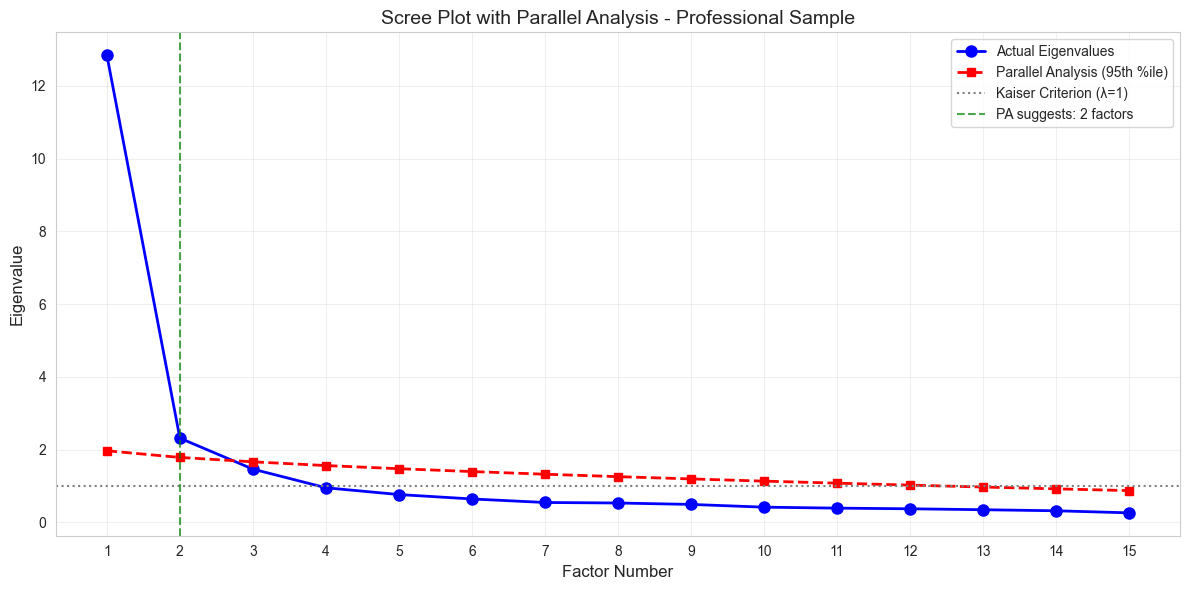


✓ Scree plot saved to plots/01_scree_plot_parallel_analysis.png


In [38]:
# Scree Plot with Parallel Analysis
fig, ax = plt.subplots(figsize=(12, 6))

factors_to_plot = min(15, len(ev))
x = range(1, factors_to_plot + 1)

# Plot actual eigenvalues
ax.plot(x, ev[:factors_to_plot], 'b-o', linewidth=2, markersize=8, label='Actual Eigenvalues')

# Plot parallel analysis threshold
ax.plot(x, random_ev[:factors_to_plot], 'r--s', linewidth=2, markersize=6, label='Parallel Analysis (95th %ile)')

# Kaiser criterion line
ax.axhline(y=1, color='gray', linestyle=':', linewidth=1.5, label='Kaiser Criterion (λ=1)')

# Mark recommended factors
ax.axvline(x=n_factors_pa, color='green', linestyle='--', alpha=0.7, label=f'PA suggests: {n_factors_pa} factors')

ax.set_xlabel('Factor Number', fontsize=12)
ax.set_ylabel('Eigenvalue', fontsize=12)
ax.set_title('Scree Plot with Parallel Analysis - Professional Sample', fontsize=14)
ax.legend(loc='upper right')
ax.set_xticks(x)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('plots/01_scree_plot_parallel_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Scree plot saved to plots/01_scree_plot_parallel_analysis.png")

## 6. Initial EFA - Parallel Analysis Solution

In [39]:
# Use parallel analysis recommended number of factors
n_factors = n_factors_pa

print(f"Fitting EFA with {n_factors} factors (Parallel Analysis recommendation)")
print(f"  Estimator: MINRES (robust to non-normality)")
print(f"  Rotation: Promax (oblique - factors expected to correlate)")

# Fit EFA
efa = FactorAnalyzer(n_factors=n_factors, rotation='promax', method='minres')
efa.fit(df_efa)

# Get loadings
loadings = pd.DataFrame(
    efa.loadings_,
    index=predictor_items,
    columns=[f'F{i+1}' for i in range(n_factors)]
)

print(f"\n✓ EFA fitted successfully")

Fitting EFA with 2 factors (Parallel Analysis recommendation)
  Estimator: MINRES (robust to non-normality)
  Rotation: Promax (oblique - factors expected to correlate)

✓ EFA fitted successfully


In [40]:
# Pattern Matrix (loadings)
def highlight_loadings(val):
    """Highlight significant loadings."""
    if abs(val) >= 0.50:
        return 'background-color: lightgreen; font-weight: bold'
    elif abs(val) >= 0.32:
        return 'background-color: lightyellow'
    return ''

# Add construct labels
loadings['Construct'] = [metadata[item]['construct_abbr'] for item in loadings.index]

print(f"Pattern Matrix ({n_factors}-factor solution):")
print("Green = Primary loading (≥0.50), Yellow = Cross-loading (≥0.32)")

# Display styled loadings
factor_cols = [f'F{i+1}' for i in range(n_factors)]
styled = loadings[factor_cols].style.applymap(highlight_loadings).format('{:.3f}')
display(styled)

Pattern Matrix (2-factor solution):
Green = Primary loading (≥0.50), Yellow = Cross-loading (≥0.32)


,F1,F2
PE1,0.842,0.019
PE2,0.854,-0.030
EE1,0.737,-0.009
EE2,0.727,0.006
SI1,0.808,-0.057
SI2,0.717,0.010
FC1,0.663,-0.007
FC2,0.735,-0.018
HM1,0.836,-0.033
HM2,0.866,-0.020


In [41]:
# Communalities
communalities = pd.DataFrame({
    'Item': predictor_items,
    'Construct': [metadata[item]['construct_abbr'] for item in predictor_items],
    'Communality': efa.get_communalities()
})

print("Communalities (variance explained by factors):")
print("Flag: < 0.40 indicates item may not fit well")

communalities['Flag'] = communalities['Communality'].apply(
    lambda x: '⚠️ Low' if x < 0.40 else '✓'
)

display(communalities.round(3))

low_comm = communalities[communalities['Communality'] < 0.40]
if len(low_comm) > 0:
    print(f"\n⚠️ {len(low_comm)} item(s) with communality < 0.40")

Communalities (variance explained by factors):
Flag: < 0.40 indicates item may not fit well


,Item,Construct,Communality,Flag
0,PE1,PE,0.709,✓
1,PE2,PE,0.729,✓
2,EE1,EE,0.543,✓
3,EE2,EE,0.528,✓
4,SI1,SI,0.656,✓
5,SI2,SI,0.514,✓
6,FC1,FC,0.440,✓
7,FC2,FC,0.540,✓
8,HM1,HM,0.700,✓
9,HM2,HM,0.751,✓



⚠️ 1 item(s) with communality < 0.40


In [42]:
# Factor Correlations (for oblique rotation)
if hasattr(efa, 'phi_'):
    factor_corr = pd.DataFrame(
        efa.phi_,
        index=[f'F{i+1}' for i in range(n_factors)],
        columns=[f'F{i+1}' for i in range(n_factors)]
    )
    print("Factor Correlation Matrix (Phi):")
    display(factor_corr.round(3))
else:
    print("Factor correlations not available (orthogonal rotation)")

Factor Correlation Matrix (Phi):


,F1,F2
F1,1.000,-0.009
F2,-0.009,1.000


In [43]:
# Variance Explained
variance = efa.get_factor_variance()

var_df = pd.DataFrame({
    'Factor': [f'F{i+1}' for i in range(n_factors)],
    'SS Loadings': variance[0],
    'Proportion Var': variance[1],
    'Cumulative Var': variance[2]
})

print("Variance Explained:")
display(var_df.round(3))

total_var = variance[2][-1] * 100
print(f"\nTotal variance explained: {total_var:.1f}%")

Variance Explained:


,Factor,SS Loadings,Proportion Var,Cumulative Var
0,F1,12.475,0.520,0.520
1,F2,1.821,0.076,0.596



Total variance explained: 59.6%


## 7. Item Quality Assessment

In [44]:
def assess_item_quality(loadings_df, communalities_series, threshold_primary=0.50, threshold_cross=0.32):
    """
    Assess item quality based on:
    - Primary loading ≥ threshold_primary
    - No cross-loadings ≥ threshold_cross (or difference > 0.20)
    - Communality ≥ 0.40
    """
    results = []
    factor_cols = [col for col in loadings_df.columns if col.startswith('F')]
    
    for item in loadings_df.index:
        row = loadings_df.loc[item, factor_cols].abs()
        sorted_loadings = row.sort_values(ascending=False)
        
        primary_factor = sorted_loadings.index[0]
        primary_loading = sorted_loadings.iloc[0]
        secondary_loading = sorted_loadings.iloc[1] if len(sorted_loadings) > 1 else 0
        
        comm = communalities_series[item] if item in communalities_series.index else communalities_series.iloc[list(loadings_df.index).index(item)]
        
        # Check criteria
        issues = []
        
        if primary_loading < threshold_primary:
            issues.append(f'Low primary ({primary_loading:.2f})')
        
        if secondary_loading >= threshold_cross and (primary_loading - secondary_loading) < 0.20:
            issues.append(f'Cross-loading ({secondary_loading:.2f})')
        
        if comm < 0.40:
            issues.append(f'Low communality ({comm:.2f})')
        
        status = '✓ Good' if len(issues) == 0 else '⚠️ ' + '; '.join(issues)
        
        results.append({
            'Item': item,
            'Construct': metadata[item]['construct_abbr'],
            'Primary_Factor': primary_factor,
            'Primary_Loading': primary_loading,
            'Secondary_Loading': secondary_loading,
            'Communality': comm,
            'Status': status
        })
    
    return pd.DataFrame(results)

# Create communalities series
comm_series = pd.Series(efa.get_communalities(), index=predictor_items)

# Assess quality
quality_df = assess_item_quality(loadings, comm_series)

print("Item Quality Assessment:")
display(quality_df.round(3))

# Summary
good_items = quality_df[quality_df['Status'] == '✓ Good']
problem_items = quality_df[quality_df['Status'] != '✓ Good']

print(f"\n✓ Good items: {len(good_items)}/{len(quality_df)}")
print(f"⚠️ Problem items: {len(problem_items)}/{len(quality_df)}")

Item Quality Assessment:


,Item,Construct,Primary_Factor,Primary_Loading,Secondary_Loading,Communality,Status
0,PE1,PE,F1,0.842,0.019,0.709,✓ Good
1,PE2,PE,F1,0.854,0.030,0.729,✓ Good
2,EE1,EE,F1,0.737,0.009,0.543,✓ Good
3,EE2,EE,F1,0.727,0.006,0.528,✓ Good
4,SI1,SI,F1,0.808,0.057,0.656,✓ Good
5,SI2,SI,F1,0.717,0.010,0.514,✓ Good
6,FC1,FC,F1,0.663,0.007,0.440,✓ Good
7,FC2,FC,F1,0.735,0.018,0.540,✓ Good
8,HM1,HM,F1,0.836,0.033,0.700,✓ Good
9,HM2,HM,F1,0.866,0.020,0.751,✓ Good



✓ Good items: 23/24
⚠️ Problem items: 1/24


In [45]:
# Items flagged for potential removal
if len(problem_items) > 0:
    print("Items to consider for removal/review:")
    display(problem_items[['Item', 'Construct', 'Primary_Loading', 'Secondary_Loading', 'Communality', 'Status']])
else:
    print("✓ All items meet quality criteria")

Items to consider for removal/review:


,Item,Construct,Primary_Loading,Secondary_Loading,Communality,Status
15,VO2,VO,0.333163,0.217213,0.158179,⚠️ Low primary (0.33); Low communality (0.16)


## 8. Factor-Construct Alignment

In [46]:
# Map factors to theoretical constructs
def map_factors_to_constructs(quality_df, constructs_dict):
    """Map extracted factors to theoretical constructs based on item loadings."""
    factor_mapping = {}
    
    for factor in quality_df['Primary_Factor'].unique():
        factor_items = quality_df[quality_df['Primary_Factor'] == factor]
        construct_counts = factor_items['Construct'].value_counts()
        
        if len(construct_counts) > 0:
            primary_construct = construct_counts.index[0]
            items_from_construct = construct_counts.iloc[0]
            total_items = len(factor_items)
            
            factor_mapping[factor] = {
                'Primary_Construct': primary_construct,
                'Items_From_Construct': items_from_construct,
                'Total_Items': total_items,
                'Purity': items_from_construct / total_items,
                'All_Constructs': construct_counts.to_dict()
            }
    
    return factor_mapping

factor_mapping = map_factors_to_constructs(quality_df, constructs)

print("Factor-Construct Alignment:")
for factor, info in sorted(factor_mapping.items()):
    purity_pct = info['Purity'] * 100
    status = '✓' if purity_pct >= 80 else '⚠️'
    print(f"  {factor} → {info['Primary_Construct']} ({info['Items_From_Construct']}/{info['Total_Items']} items, {purity_pct:.0f}% purity) {status}")
    if info['Purity'] < 1.0:
        other_constructs = {k: v for k, v in info['All_Constructs'].items() if k != info['Primary_Construct']}
        if other_constructs:
            print(f"       Also includes: {other_constructs}")

Factor-Construct Alignment:
  F1 → PE (2/20 items, 10% purity) ⚠️
       Also includes: {'EE': 2, 'SI': 2, 'FC': 2, 'HM': 2, 'PV': 2, 'HB': 2, 'VO': 2, 'TR': 2, 'EX': 2}
  F2 → ER (2/4 items, 50% purity) ⚠️
       Also includes: {'AX': 2}


In [47]:
# Check construct coverage
def check_construct_coverage(quality_df, constructs_dict, min_items=2):
    """Check if each theoretical construct has minimum items with good loadings."""
    coverage = {}
    
    for construct, items in constructs_dict.items():
        if construct == 'BI':  # Skip outcome variable
            continue
            
        # Items from this construct with good primary loadings
        construct_items = quality_df[quality_df['Construct'] == construct]
        good_items = construct_items[construct_items['Primary_Loading'] >= 0.50]
        
        coverage[construct] = {
            'Theoretical_Items': len(items),
            'Items_in_EFA': len(construct_items),
            'Good_Items': len(good_items),
            'Status': '✓' if len(good_items) >= min_items else '⚠️ COVERAGE ISSUE'
        }
    
    return pd.DataFrame(coverage).T

coverage_df = check_construct_coverage(quality_df, constructs)

print("Construct Coverage Check (minimum 2 items per construct):")
display(coverage_df)

coverage_issues = coverage_df[coverage_df['Status'] != '✓']
if len(coverage_issues) > 0:
    print(f"\n⚠️ {len(coverage_issues)} construct(s) with coverage issues")
else:
    print(f"\n✓ All constructs have adequate coverage")

Construct Coverage Check (minimum 2 items per construct):


,Theoretical_Items,Items_in_EFA,Good_Items,Status
PE,2,2,2,✓
EE,2,2,2,✓
SI,2,2,2,✓
FC,2,2,2,✓
HM,2,2,2,✓
PV,2,2,2,✓
HB,2,2,2,✓
VO,2,2,1,⚠️ COVERAGE ISSUE
TR,2,2,2,✓
EX,2,2,2,✓



⚠️ 1 construct(s) with coverage issues


## 9. Reliability Analysis

In [48]:
def calculate_cronbach_alpha(data):
    """Calculate Cronbach's alpha for a set of items."""
    n_items = data.shape[1]
    if n_items < 2:
        return np.nan
    
    item_vars = data.var(axis=0, ddof=1)
    total_var = data.sum(axis=1).var(ddof=1)
    
    alpha = (n_items / (n_items - 1)) * (1 - item_vars.sum() / total_var)
    return alpha

# Calculate reliability for each factor based on items loading on it
reliability_results = []

for factor in sorted(quality_df['Primary_Factor'].unique()):
    factor_items = quality_df[quality_df['Primary_Factor'] == factor]['Item'].tolist()
    
    if len(factor_items) >= 2:
        alpha = calculate_cronbach_alpha(df_efa[factor_items])
        construct = quality_df[quality_df['Primary_Factor'] == factor]['Construct'].mode().iloc[0]
        
        reliability_results.append({
            'Factor': factor,
            'Primary_Construct': construct,
            'N_Items': len(factor_items),
            'Cronbach_Alpha': alpha,
            'Status': '✓' if alpha >= 0.70 else '⚠️ Low' if alpha >= 0.60 else '❌ Poor'
        })

reliability_df = pd.DataFrame(reliability_results)

print("Factor Reliability (Cronbach's Alpha):")
print("Thresholds: ≥0.70 Good, 0.60-0.69 Acceptable, <0.60 Poor")
display(reliability_df.round(3))

Factor Reliability (Cronbach's Alpha):
Thresholds: ≥0.70 Good, 0.60-0.69 Acceptable, <0.60 Poor


,Factor,Primary_Construct,N_Items,Cronbach_Alpha,Status
0,F1,EE,20,0.968,✓
1,F2,AX,4,0.744,✓


## 10. Factor Structure Visualization

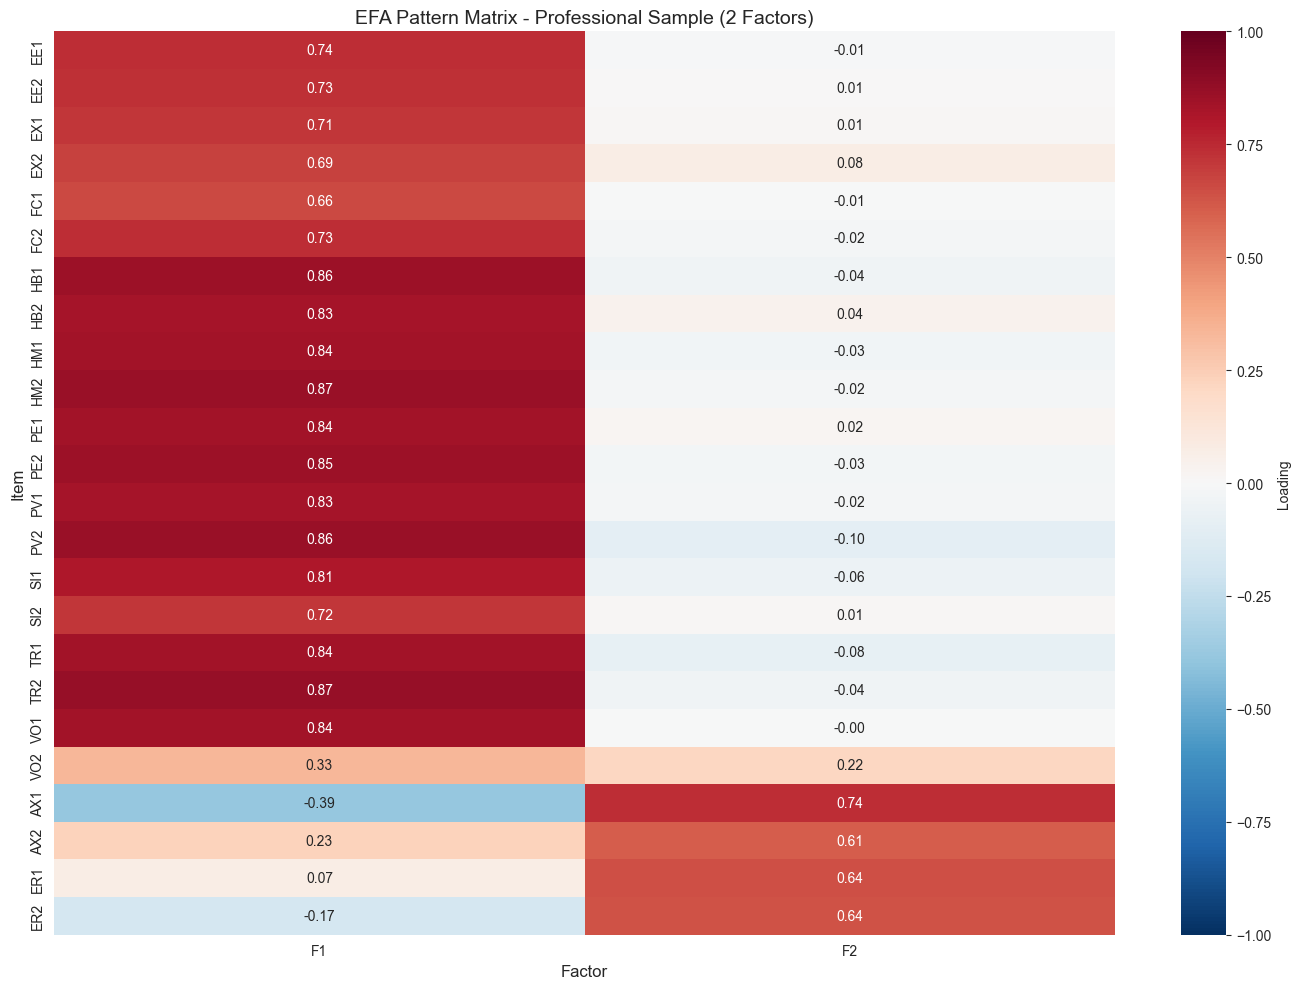


✓ Pattern matrix heatmap saved to plots/01_pattern_matrix_heatmap.png


In [49]:
# Heatmap of factor loadings
fig, ax = plt.subplots(figsize=(14, 10))

# Prepare data for heatmap
factor_cols = [f'F{i+1}' for i in range(n_factors)]
heatmap_data = loadings[factor_cols].copy()

# Sort by primary loading factor
heatmap_data['Primary'] = heatmap_data.abs().idxmax(axis=1)
heatmap_data['Construct'] = [metadata[item]['construct_abbr'] for item in heatmap_data.index]
heatmap_data = heatmap_data.sort_values(['Primary', 'Construct'])
heatmap_data = heatmap_data.drop(['Primary', 'Construct'], axis=1)

# Create heatmap
sns.heatmap(
    heatmap_data,
    annot=True,
    fmt='.2f',
    cmap='RdBu_r',
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    cbar_kws={'label': 'Loading'}
)

ax.set_title(f'EFA Pattern Matrix - Professional Sample ({n_factors} Factors)', fontsize=14)
ax.set_xlabel('Factor', fontsize=12)
ax.set_ylabel('Item', fontsize=12)

plt.tight_layout()
plt.savefig('plots/01_pattern_matrix_heatmap.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"\n✓ Pattern matrix heatmap saved to plots/01_pattern_matrix_heatmap.png")

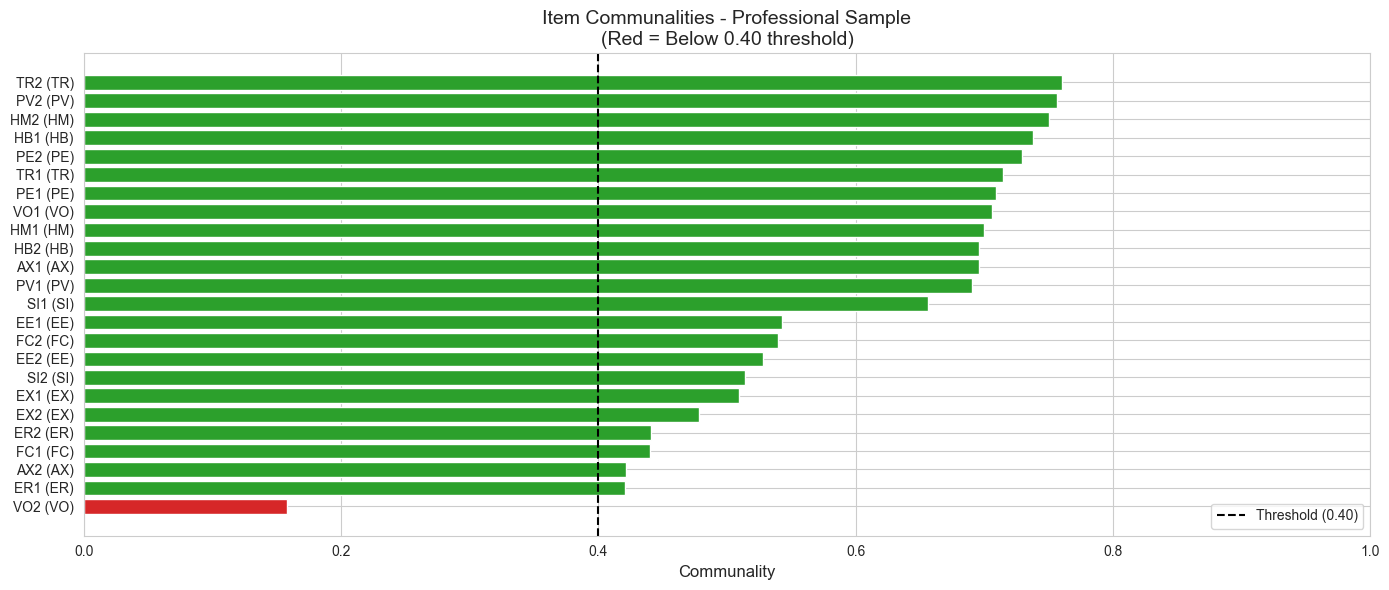


✓ Communality chart saved to plots/01_communality_chart.png
   Items below threshold: 1/24


In [50]:
# Communality Bar Chart - Visualize item quality
fig, ax = plt.subplots(figsize=(14, 6))

# Get communalities and sort
comm_data = pd.DataFrame({
    'Item': loadings.index,
    'Communality': efa.get_communalities(),
    'Construct': [metadata[item]['construct_abbr'] for item in loadings.index]
})
comm_data = comm_data.sort_values('Communality', ascending=True)

# Color by threshold
colors = ['#d62728' if c < 0.4 else '#2ca02c' for c in comm_data['Communality']]

bars = ax.barh(range(len(comm_data)), comm_data['Communality'], color=colors)

# Add threshold line
ax.axvline(x=0.4, color='black', linestyle='--', linewidth=1.5, label='Threshold (0.40)')

# Labels
ax.set_yticks(range(len(comm_data)))
ax.set_yticklabels([f"{row['Item']} ({row['Construct']})" for _, row in comm_data.iterrows()])
ax.set_xlabel('Communality', fontsize=12)
ax.set_title('Item Communalities - Professional Sample\n(Red = Below 0.40 threshold)', fontsize=14)
ax.set_xlim(0, 1)
ax.legend(loc='lower right')

plt.tight_layout()
plt.savefig('plots/01_communality_chart.png', dpi=150, bbox_inches='tight')
plt.show()

n_low = sum(comm_data['Communality'] < 0.4)
print(f"\n✓ Communality chart saved to plots/01_communality_chart.png")
print(f"   Items below threshold: {n_low}/24")

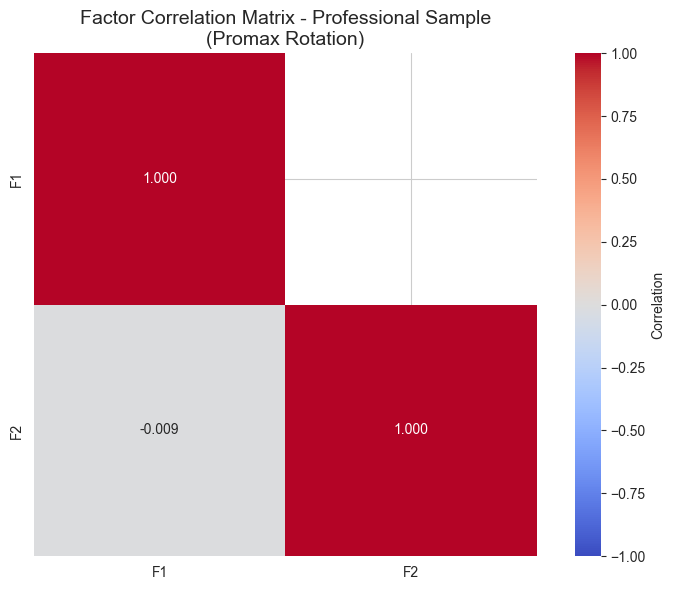


✓ Factor correlation saved to plots/01_factor_correlation.png
   F1-F2 correlation: r = -0.009
   → Consider orthogonal rotation (r ≤ .32)


In [51]:
# Factor Correlation Matrix - Important for oblique rotation justification
fig, ax = plt.subplots(figsize=(8, 6))

# Get factor correlation matrix
factor_corr = pd.DataFrame(
    efa.phi_,  # Factor correlation matrix from Promax rotation
    index=[f'F{i+1}' for i in range(n_factors)],
    columns=[f'F{i+1}' for i in range(n_factors)]
)

# Create heatmap
mask = np.triu(np.ones_like(factor_corr, dtype=bool), k=1)  # Upper triangle mask
sns.heatmap(
    factor_corr,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    vmin=-1,
    vmax=1,
    ax=ax,
    mask=mask,
    square=True,
    cbar_kws={'label': 'Correlation'}
)

ax.set_title(f'Factor Correlation Matrix - Professional Sample\n(Promax Rotation)', fontsize=14)

plt.tight_layout()
plt.savefig('plots/01_factor_correlation.png', dpi=150, bbox_inches='tight')
plt.show()

# Report correlation
if n_factors == 2:
    r = factor_corr.iloc[0, 1]
    print(f"\n✓ Factor correlation saved to plots/01_factor_correlation.png")
    print(f"   F1-F2 correlation: r = {r:.3f}")
    if abs(r) > 0.32:
        print("   → Oblique rotation justified (r > .32)")
    else:
        print("   → Consider orthogonal rotation (r ≤ .32)")

## 11. Export Results

In [52]:
# Save pattern matrix
loadings_export = loadings.copy()
loadings_export['Construct'] = [metadata[item]['construct_abbr'] for item in loadings_export.index]
loadings_export['Communality'] = efa.get_communalities()
loadings_export.to_csv('tables/01_pattern_matrix.csv')

# Save item quality assessment
quality_df.to_csv('tables/01_item_quality.csv', index=False)

# Save reliability
reliability_df.to_csv('tables/01_factor_reliability.csv', index=False)

# Save eigenvalues
eigen_df.to_csv('tables/01_eigenvalues.csv', index=False)

print("✓ Results exported to tables/")
print("  - 01_pattern_matrix.csv")
print("  - 01_item_quality.csv")
print("  - 01_factor_reliability.csv")
print("  - 01_eigenvalues.csv")

✓ Results exported to tables/
  - 01_pattern_matrix.csv
  - 01_item_quality.csv
  - 01_factor_reliability.csv
  - 01_eigenvalues.csv


In [53]:
# Export EFA solution as JSON for downstream notebooks
efa_solution = {
    'population': POPULATION,
    'n_dev': int(len(df_dev)),
    'n_factors': int(n_factors),
    'method': 'minres',
    'rotation': 'promax',
    'total_variance_explained': float(variance[2][-1]),
    'kmo': float(kmo_model),
    'bartlett_chi2': float(chi_square),
    'bartlett_p': float(p_value),
    'factor_mapping': {k: v['Primary_Construct'] for k, v in factor_mapping.items()},
    'items_per_factor': {factor: quality_df[quality_df['Primary_Factor'] == factor]['Item'].tolist() 
                         for factor in quality_df['Primary_Factor'].unique()},
    'reliability': {row['Factor']: float(row['Cronbach_Alpha']) for _, row in reliability_df.iterrows()},
    'problem_items': problem_items['Item'].tolist() if len(problem_items) > 0 else []
}

with open('data/efa_solution.json', 'w') as f:
    json.dump(efa_solution, f, indent=2)

print("✓ EFA solution exported to data/efa_solution.json")

✓ EFA solution exported to data/efa_solution.json


## 12. Summary & Recommendations

In [54]:
# Generate summary
print("="*60)
print("EFA SUMMARY - PROFESSIONAL SAMPLE")
print("="*60)
print(f"\nSample: N = {len(df_dev)} (development)")
print(f"Items analyzed: {len(predictor_items)}")
print(f"Subjects:items ratio: {len(df_dev)/len(predictor_items):.1f}:1")
print(f"\nFactorability:")
print(f"  KMO: {kmo_model:.3f} ({kmo_interpretation})")
print(f"  Bartlett's χ²: {chi_square:.2f}, p < .001")
print(f"\nFactor Solution:")
print(f"  Factors extracted: {n_factors} (Parallel Analysis)")
print(f"  Variance explained: {total_var:.1f}%")
print(f"  Method: MINRES with Promax rotation")
print(f"\nItem Quality:")
print(f"  Good items: {len(good_items)}/{len(quality_df)}")
print(f"  Problem items: {len(problem_items)}/{len(quality_df)}")
print(f"\nConstruct Coverage:")
print(f"  Constructs with adequate coverage: {len(coverage_df[coverage_df['Status'] == '✓'])}/{len(coverage_df)}")
print(f"\nReliability:")
good_alpha = len(reliability_df[reliability_df['Cronbach_Alpha'] >= 0.70])
print(f"  Factors with α ≥ 0.70: {good_alpha}/{len(reliability_df)}")

EFA SUMMARY - PROFESSIONAL SAMPLE

Sample: N = 145 (development)
Items analyzed: 24
Subjects:items ratio: 6.0:1

Factorability:
  KMO: 0.928 (Marvelous)
  Bartlett's χ²: 3116.01, p < .001

Factor Solution:
  Factors extracted: 2 (Parallel Analysis)
  Variance explained: 59.6%
  Method: MINRES with Promax rotation

Item Quality:
  Good items: 23/24
  Problem items: 1/24

Construct Coverage:
  Constructs with adequate coverage: 11/12

Reliability:
  Factors with α ≥ 0.70: 2/2


In [55]:
# Recommendations
print("\nRECOMMENDATIONS:")
print("-"*40)

if len(problem_items) > 0:
    print(f"\n1. Review problematic items:")
    for _, row in problem_items.iterrows():
        print(f"   - {row['Item']} ({row['Construct']}): {row['Status']}")

if len(coverage_issues) > 0:
    print(f"\n2. Address coverage issues:")
    for construct in coverage_issues.index:
        print(f"   - {construct}: Only {coverage_issues.loc[construct, 'Good_Items']} items with good loadings")

low_reliability = reliability_df[reliability_df['Cronbach_Alpha'] < 0.70]
if len(low_reliability) > 0:
    print(f"\n3. Improve factor reliability:")
    for _, row in low_reliability.iterrows():
        print(f"   - {row['Factor']} ({row['Primary_Construct']}): α = {row['Cronbach_Alpha']:.3f}")

print(f"\n4. Next Steps:")
print(f"   - Run CFA on holdout sample (N=146) to confirm structure")
print(f"   - Compare with Full and Academic EFA solutions")
print(f"   - Note: VO (Voluntariness) may be weak in professional context")


RECOMMENDATIONS:
----------------------------------------

1. Review problematic items:
   - VO2 (VO): ⚠️ Low primary (0.33); Low communality (0.16)

2. Address coverage issues:
   - VO: Only 1 items with good loadings

4. Next Steps:
   - Run CFA on holdout sample (N=146) to confirm structure
   - Compare with Full and Academic EFA solutions
   - Note: VO (Voluntariness) may be weak in professional context


## 13. APA Method Summary

In [56]:
# Dynamic APA-formatted method summary using f-strings
n_dev = len(df_dev)
n_items = len(predictor_items)
n_constructs = len([c for c in constructs.keys() if c != 'BI'])
subjects_per_item = n_dev / n_items

apa_summary = f"""
### Method Summary (APA Format)

**Exploratory Factor Analysis - Professional Sample**

An exploratory factor analysis (EFA) was conducted on the {n_items} predictor items using the 
professional development sample (*N* = {n_dev}). The subjects-to-items ratio was {subjects_per_item:.1f}:1, 
which is {'adequate' if subjects_per_item >= 5 else 'below the recommended 5:1 minimum'} for factor analysis 
(Costello & Osborne, 2005).

Prior to analysis, the suitability of the data for factor analysis was assessed. The Kaiser-Meyer-Olkin 
measure of sampling adequacy was {kmo_model:.2f}, indicating {kmo_interpretation.lower()} factorability 
(Kaiser, 1974). Bartlett's test of sphericity was significant, χ²({n_items * (n_items - 1) // 2}) = 
{chi_square:.2f}, *p* < .001, indicating that correlations between items were sufficiently large for 
factor analysis.

Factor extraction was performed using the MINRES method, which is robust to violations of normality 
assumptions. The number of factors to retain was determined through parallel analysis (Horn, 1965), 
which suggested a {n_factors}-factor solution. This is {'consistent with' if 10 <= n_factors <= 12 else 'different from'} 
the theoretical expectation of 10-12 factors for the professional sample.

An oblique rotation (Promax) was applied given the theoretical expectation that the constructs would 
be correlated. The {n_factors}-factor solution explained {total_var:.1f}% of the total variance. 

Items were evaluated using standard retention criteria: primary loading ≥ .50, no cross-loadings ≥ .32 
(or a difference of at least .20 between primary and secondary loadings), and communality ≥ .40. Of 
the {n_items} items analyzed, {len(good_items)} met all retention criteria and {len(problem_items)} 
were flagged for review.

Internal consistency reliability was assessed using Cronbach's alpha for each factor. {good_alpha} of 
{len(reliability_df)} factors demonstrated acceptable reliability (α ≥ .70).

The factor solution will be cross-validated using confirmatory factor analysis on the independent 
holdout sample (*N* = 146).
"""

display(Markdown(apa_summary))


### Method Summary (APA Format)

**Exploratory Factor Analysis - Professional Sample**

An exploratory factor analysis (EFA) was conducted on the 24 predictor items using the 
professional development sample (*N* = 145). The subjects-to-items ratio was 6.0:1, 
which is adequate for factor analysis 
(Costello & Osborne, 2005).

Prior to analysis, the suitability of the data for factor analysis was assessed. The Kaiser-Meyer-Olkin 
measure of sampling adequacy was 0.93, indicating marvelous factorability 
(Kaiser, 1974). Bartlett's test of sphericity was significant, χ²(276) = 
3116.01, *p* < .001, indicating that correlations between items were sufficiently large for 
factor analysis.

Factor extraction was performed using the MINRES method, which is robust to violations of normality 
assumptions. The number of factors to retain was determined through parallel analysis (Horn, 1965), 
which suggested a 2-factor solution. This is different from 
the theoretical expectation of 10-12 factors for the professional sample.

An oblique rotation (Promax) was applied given the theoretical expectation that the constructs would 
be correlated. The 2-factor solution explained 59.6% of the total variance. 

Items were evaluated using standard retention criteria: primary loading ≥ .50, no cross-loadings ≥ .32 
(or a difference of at least .20 between primary and secondary loadings), and communality ≥ .40. Of 
the 24 items analyzed, 23 met all retention criteria and 1 
were flagged for review.

Internal consistency reliability was assessed using Cronbach's alpha for each factor. 2 of 
2 factors demonstrated acceptable reliability (α ≥ .70).

The factor solution will be cross-validated using confirmatory factor analysis on the independent 
holdout sample (*N* = 146).
